Chengyu Dai, Cupjin Huang, Kevin Sung

generated by Jupyter notebook

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import networkx as nx
from networkx.algorithms import bipartite

import itertools
import json
eps = 1e-10

# Problem Statement:
In the generalized assignment problem, we are given a collection of $n$ jobs to be assigned to $m$ machines. Each job $j = 1, . . . , n$ is to be assigned to exactly one machine; if it is assigned to machine $i$, then it requires $p_{ij}$ time units of processing, and incurs a cost of $c_{ij}$. Furthermore, we are given a time bound $T$ that limits the total processing of each machine $i = 1, . . . , m$. The aim is to find a feasible assignment of minimum total cost.


- Input : 

 + number of jobs $n$,
 
 + number of machines $m$,
 
 + cost matrix $[c_{ij}]$,
 
 + processing time matrix $[p_{ij}]$,
 
 + time bound $T$.
 
- Output: $w\in [m]^n$, where $w_i$ is the machine where job $i$ is assigned to

## IP Formulation:
Denote $x_{ij}$ be the indicator of whether job $i$ is assigned to machine $j$. Then our problem can be formulated as the following IP:

\begin{equation*}
\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle\sum\limits_{i,j} x_{ij}&c_{ij} &\\
\text{subject to}& \displaystyle\sum\limits_{j=1}^m   &x_{ij} = 1,  &i=1 ,..., n\\
                  & \displaystyle\sum\limits_{i=1}^n   &p_{ij}x_{ij} \leq  T,  &j=1 ,\cdots, m\\
                 &                                                &x_{ij} \in \{0,1\}, &i=1,\cdots,n,\\
                 & & &j=1 ,\cdots, m
\end{array}
\end{equation*}

# Approximation Algorihm
The IP above cannot be solved both exactly and efficiently assuming $\mathcal{NP}\neq \mathcal{P}$. Here we will present an algorithm which gives a solution such that

- The cost is at most the optimal cost of the original problem;

- Each machine terminates before time $2T$.

The algorithm consists of three parts:

1. Solve the LP relaxation of the original IP

2. Construct a bipartite graph based on the fractional solution

3. Determinsticly round the fractional solution to integral with the help of the bipartite graph 

In [2]:
def genAssign(p,c,T, show=False):
    '''
    Generate an assignment with maximum completion time <= 2T and total cost <= LP.
    Input:
        p: processing time matrix with dimension mxn
        c: cost matrix with dimension mxn
        T: time bound
        show: whether intermediate results are to be printed
    Output:
        res: an array indicating the assignment
        f: the LP value
    '''
    x,f = getLPSol(p,c,T)
    if x == None:
        return None, f
    B = buildGraph(x,p)
    res = detRound(B, c,show)
    return res, f

## LP Relaxation


Consider the following LP relaxation:

\begin{equation*}
\begin{array}{ll@{}ll}
\text{minimize}  & \displaystyle\sum\limits_{i,j} x_{ij}&c_{ij} &\\
\text{subject to}& \displaystyle\sum\limits_{j=1}^m   &x_{ij} = 1,  &i=1 ,..., n\\
                  & \displaystyle\sum\limits_{i=1}^n   &p_{ij}x_{ij} \leq  T,  &j=1 ,\cdots, m\\
                 &                                                &x_{ij} \geq 0, &i=1,\cdots,n,\\
                 & & &j=1 ,\cdots, m
\end{array}
\end{equation*}

Solving this LP gives us a fractional solution $\mathbf{x}\in [0,1]^{n\times m}$.

In [3]:
def getLPSol(p, c, T):
    """
    Get a solution to the LP. There are n jobs and m machines
    Inputs:
        p: an mxn matrix
        c: an mxn matrix
        T: a number
    Output: an mxn matrix
    """
    # get LP dimensions
    m = p.shape[0]
    n = p.shape[1]

    d = np.empty(m * n)         # coefficient vector
    A_ub = np.zeros((m, m * n)) # upper bound constraint matrix
    b_ub = T * np.ones(m)       # upper bound constraint vector
    A_eq = np.zeros((n, m * n)) # equality constraint matrix
    b_eq = np.ones(n)           # equality constraint vector
    bounds = []                 # bounds on variables

    # construct coefficient vector and set variable bounds
    for i in range(m):
        for j in range(n):
            # construct coefficient vector
            d[i * n + j] = c[i, j]
            # set variable bounds
            if p[i, j] > T:
                bounds.append((0, 0))
            else:
                bounds.append((0, None))

    # construct upper bound matrix
    for i in range(m):
        for j in range(n):
            A_ub[i, i * n + j] = p[i, j]

    # construct equality constraint matrix
    for j in range(n):
        for i in range(m):
            A_eq[j, i * n + j] = 1

    # get LP solution
    res = linprog(d, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    if res.status != 0:
        return None, res.fun
    return np.reshape(res.x, (m, n)), res.fun

## Constructing Bipartite Graph

Let $k_j = \lceil\sum_{i=1}^n x_{ij}\rceil$. Define a bipartite graph $(A,B)$, where $A=[n]$ and $B=\{(j,s)|j\in[m], s\in[s_j]\}$. We illustrate the edges in the bipartite graph by only looking at the case $j=1$.

For $j=1$, consider only the jobs $i$ such that $x_{i1}>0$ (assume this is $[n]$ wlog). Assume that $p_{11}\geq p_{21}\geq\cdots p_{n1}$ without loss of generality (sort them if necessary). For each $i'$, we track the partial sum $\sum_{i=1}^{i'}x_{i1}$.

- If $\sum_{i=1}^{i'}x_{i1}\leq s, \sum_{i=1}^{i'-1}x_{i1}\geq s-1$, then add an edge $(i,(1,s))$ with weight $x_{i'1}$;
- If $\sum_{i=1}^{i'}x_{i1}> s, \sum_{i=1}^{i'-1}x_{i1}< s-1$, then add an edge $(i,(1,s-1))$ with weight $s-\sum_{i=1}^{i'-1}x_{i1}$ and an edge $(i,(1,s))$ with weight $\sum_{i=1}^{i'}x_{i1}-s$.

In [4]:
def buildGraph(x, p,):
    """
    Convert an LP solution to a bipartite graph with fractional
    edge weights where one side represents jobs and the other side
    represents slots
    Inputs:
        x: an mxn matrix
        p: an mxn matrix. These are the job completion times.
        It's required because we need to sort the rows
        of x based on the entries of p.
    Output: a nxmxn array B, where B[j, i, s] represents the weight
    on the edge from job j to slot s of machine i.
    """
    m = x.shape[0]
    n = x.shape[1]

    B = np.zeros((n, m, n))

    for i in range(m):
        s = 0       # current slot in machine i
        left = 1    # space left in current slot
        x_indices = np.argsort(-p[i]) # indices of x when p_i is in nondecreasing order
        for j in x_indices:
            y = x[i, j]
            if y <= left:
                # we can fit this job into slot s
                B[j, i, s] = y
                left -= y
            else:
                # we need to split this job into two slots
                B[j, i, s] = left       # fill up current slot
                s += 1                  # increment slot
                B[j, i, s] = y - left   # put remaining weight in new slot
                left = 1 - (y - left)   # update space left in new slot

    return B

## Deterministic Rounding

Note that the bipartite graph is a fractional min-cost perfect matching of the underlying cost function $C(i,(j,s))=c_{ij}$. It can be shown that all extreme points of the polytope are integral, and there is a way to convert the fractional solution into an integral one within polynomial time, without increasing the objective value.

Call all edges with weight in the range $(0,1)$ _unsaturated_ and $\{0,1\}$ _saturated_. We present an iterative method such that after one loop, the number of unsaturated edges decreases by at least $1$, and the sum of weights attached to a left vertex is preserved as $1$. Since at the end there is no unsaturated edge left and each left vertex is attached to edges with weights summing up to $1$, each left vertex is mapped to a right vertex via the unique edge with weight $1$. We will see shortly that this map is also injective, proving that it is a perfect matching on the left side.

Consider the following two cases:

1. There is a cycle of unsaturated edges. Color them by blue and red alternately. By increasing the weights of all red edges by a small amount $\delta$ and decreasing the weights of blue ones by $\delta$, no LP constraints are violated provided that $\delta$ is sufficiently small. As the objective function is linear in $\delta$, there must be one direction where the objective value is not increased. We can thus move $\delta$ towards that direction until one of the red edges comes to $1$ or one of the blue edges comes to $0$. Either way we decreased the number of unsaturated edges by at least $1$.

2. Call a vertex _single_ if it is only attached to an unsaturated edge, then the weight on the vertex is easily seen as equal to the the weight of the edge. Note that no left vertex can be single since they all have weight exactly $1$. Suppose now there is no cycle of unsaturated edge left, then each maximum path of unsaturated edge must start and end at single vertices. Choose a maximum path and color the edges by blue and red alternatively. Similar to case 1, perturbing the weight of all blue and red edges by a small amount $\delta$ does not violate any of the LP constraints, and we can freely move $\delta$ until one red edge reaches $1$ or one blue edge reaches $0$. 

In [12]:
def detRound(X, C,show=False):
    '''
    Deterministicly round the input fractional min-cost perfect matching to a integral one and output it.
        Input:
            X: fractional perfect matching represented by adjacency matrix
            C: the cost matrix
        Output:
            res: result of the assignment
    '''
    n,m,k = X.shape
    res = np.ones(n,dtype='int')*(-1)
    B = np.reshape(X, (X.shape[0],m*k))
    
    # Preprocessing - get rid of all edges w/ weight 1
    for i in range(n):
        for j in range(m*k):
            if(B[i,j]>1-eps):
                res[i] = j//k
                B[i,j] = 0

    while(list(res).count(-1) != 0): # not all jobs are assigned
        cyc = cycle_bipartite(B)  # finding a cycle or augmenting path
        
        draw(B, cyc, show=show)
        pairs = round_cycle(B, cyc,k,C) # round the cycle
        if(pairs.shape[0] != 0): #  record all fulfilled edges
            for j in range(pairs.shape[0]):
                res[pairs[j,0]]= pairs[j,1] //k
                B[pairs[j,0]][pairs[j,1]]=0
        
    return res

In [13]:
def cycle_bipartite(x):
    '''
    Find a cycle or an augmenting path in a bipartite graph.
        Input: 
            x: a bipartite graph encoded in an (n,m) matrix
        Output:
            cyc: indices of a cycle, where there is an edge cyc[i][0]->cyc[i][1] and cyc[i][1]->cyc[i+1][0]
        
    '''
    cl = []
    cr = []
    st = np.where(np.sum(x, axis = 0)> eps)[0]
    xcopy = np.copy(x)
    res = dfs_right(xcopy,cl,cr,st)
    if(res == None):
        print(xcopy)
    return res
    
def dfs_left(x,cl,cr, l):
    cl.append(-1)
    for i in range(len(l)):
        cl[-1]=l[i]          
        s = cl[-1]
        t = cr[-1]
        x[s,t]=0
        llist = np.where(x[cl[-1],:] > eps)[0]
        if(cr[0] in llist):
            cr.append(cr[0])
            cyc = [cl, cr]
            return cyc
        cyc = dfs_right(x, cl, cr, llist)
        if(cyc != None):
            return cyc   
        if(len(cr)!= 0):
            x[s,t]=1
    cl.pop()
    return None

def dfs_right(x,cl,cr, l):  
    cr.append(-1)
    for i in range(len(l)):
        cr[-1]=l[i]
        s = -1
        t = cr[-1]
        if(len(cl)>0):
            s = cl[-1]
            x[s,t]=0
        rlist = np.where(x[:,t] >eps)[0]
        if(rlist.shape[0] == 0):
            if(np.where(x[:,cr[0]]>eps)[0].shape[0] == 0):
                cyc = [cl, cr]
                return cyc
        cyc = dfs_left(x, cl, cr, rlist)
        if(cyc != None):
            return cyc        
        if(len(cl)>0):
            x[s,t]=1
    cr.pop()
    return None

In [14]:
def round_cycle(B, cyc,k,C):
    '''
        Input:
            B: an adjacency matrix
            cyc: a cycle in B
            k: the number of slots for each machine
            C: the cost matrix
        Output:
            pairs: lists of edges with weight 1
            B is rounded such that at least one edge in the cycle in the graph is saturated
    '''
    
    slope = 0 # determine which direction to round
    l = len(cyc[0])
    for i in range(l):
        slope += C[cyc[1][i]// k][cyc[0][i]]-C[cyc[1][i+1]// k][cyc[0][i]]
    if(slope > eps): # flip the cycle to ensure the LP value is not increased
        cyc[0] = cyc[0][::-1]
        cyc[1] = cyc[1][::-1]
        


    w = np.amin([1-B[cyc[0][i],cyc[1][i]] for i in range(l)])
    d = np.amin([B[cyc[0][i],cyc[1][i+1]] for i in range(l)])
    c = min([w,d])
            
    pairs = []
    curr = cyc[1][0]
    for i in range(l):

        # increase the weights of red edges
        curl = cyc[0][i]
        B[curl][curr] +=  c
        if(B[curl][curr] > 1-eps): # new integral edge found
            pairs.append([curl,curr])
        # decrease the weights of blue edges
        curr = cyc[1][i+1]
        B[curl][curr] -=  c
        if(B[curl][curr] < eps):
            B[curl][curr] = 0
    return np.array(pairs)

# Test

## Correctness Test

In [15]:
def cost(res, C):
    r = 0
    for i in range(len(res)):
        if(res[i]>= 0):
            r += C[res[i],i]
    return r
def time(res, P):
    r = np.zeros((P.shape[0]))
    for i in range(len(res)):
        r[res[i]]+= P[res[i],i]
    return np.amax(r)
def cost_B(B,C,n,m):
    r = 0
    for i in range(n):
        for j in range(m):
            for k in range(n):
                r += C[j,i] * B[i,j*n+k]
    return r
    

In [18]:
flatness_c = 3
flatness_p = 2
n = 20
m = 5


for i in range(100):
    C = np.exp(flatness_c*np.random.rand(m,n))
    P = np.exp(flatness_p*np.random.rand(m,n))
    T = np.sum(P)*np.random.rand() * 0.05
    res, f = genAssign(P,C,T)
    if(res == None):
        print("There is no feasible solution!")
    else:
        print(res,f, cost(res, C), T, time(res, P))

There is no feasible solution!
There is no feasible solution!
[4 2 1 4 4 3 0 3 3 2 2 1 0 0 4 0 4 2 1 3] 34.6406526692 32.9168461457 10.6847286887 14.800653171
[0 1 4 1 0 3 2 1 1 3 0 3 4 0 4 2 1 4 3 0] 54.4997974706 49.0899229894 7.46867325106 11.1286763904


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


There is no feasible solution!
[2 3 4 4 0 2 0 3 4 0 2 2 4 1 4 0 4 3 3 0] 37.8767134818 37.6480991764 14.4559359381 16.3631305871
There is no feasible solution!
There is no feasible solution!
[1 1 1 3 0 1 4 2 2 4 2 2 1 0 4 0 2 2 1 4] 31.5702934337 30.4764972678 12.6168118777 14.4606851268
[4 2 2 4 2 1 1 2 4 1 1 3 3 3 2 0 3 4 1 3] 48.9494351958 46.6292286249 8.7382464622 10.939910134
[3 3 0 3 2 2 3 4 4 2 4 0 3 1 0 4 3 4 2 2] 41.5460282281 41.2764233582 16.9370970794 20.6519667423
[2 2 3 1 2 4 3 3 3 4 2 0 1 0 4 0 0 3 1 1] 63.9662043432 58.7157364891 7.35350333027 9.10021432861
There is no feasible solution!
There is no feasible solution!
[1 1 2 3 4 2 3 2 4 0 0 3 0 0 2 3 1 3 0 4] 37.6161026039 36.2371777337 10.8103537984 16.4535586725
[0 3 0 0 3 4 1 4 1 1 4 4 2 2 4 4 3 2 3 0] 44.1877074362 38.3898858957 9.19765075758 14.1701165169
[0 3 4 2 0 3 1 0 2 3 4 3 1 4 1 1 1 4 0 1] 40.964565511 40.0236886276 12.0122363509 15.6461475276
There is no feasible solution!
[1 1 0 1 0 2 0 0 3 4 2 4 1 2 3 3 

## Benchmark tests

In [29]:
# taken from http://astarte.csr.unibo.it/gapdata/gapinstances.html
def readjson(f):
    """ Convert json to problem instance
    Input:
        f: file object of json file
    Output:
        (p, c, T) tuple
    """
    a = json.load(f)
    p = np.array(a['req'])
    c = np.array(a['cost'])
    T = max(a['cap'])
    return p, c, T

# test

P,C,T = readjson(open('data/gapa_0.json'))
res, f = genAssign(P,C,T)
if(res == None):
    print("There is no feasible solution!")
else:
    print(f, cost(res, C), T, time(res, P))

1697.72727273 1696 342 361.0


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


## graph viz for cycle finding and rounding process

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def draw(x, cycle, show=False):
    if (show==False):
        return
#     ans = {j:i for i,j in enumerate(cycle_bipartite(x, self.start, debug=1))}
#     print(cycle)
    cycle_edges = []
    for idx, j in enumerate(cycle[-1]):
        if idx != 0:
            cycle_edges.append(("i{}".format(cycle[0][idx-1]), "j{}".format(j)))
        if idx != len(cycle[-1])-1:
            cycle_edges.append(("j{}".format(j),"i{}".format(cycle[0][idx])))

    B = nx.Graph()
    B.add_nodes_from(['i{}'.format(i) for i in range(x.shape[0])], bipartite=0)
    B.add_nodes_from(['j{}'.format(i) for i in range(x.shape[1])], bipartite=1)
    B.add_edges_from([('i{}'.format(i),'j{}'.format(j))
                      for i,j in itertools.product(range(x.shape[0]), range(x.shape[1]))
                      if x[i,j]
                     ])
    
    edge_color = []
    for edge in B.edges():
        if edge not in cycle_edges and (edge[-1],edge[0]) not in cycle_edges:
            edge_color.append(-100)
        else:
            try:
                idx = cycle_edges.index(edge)
            except:
                idx = cycle_edges.index((edge[-1],edge[0]))
            edge_color.append(idx%2)
            
    X = set(n for n,d in B.nodes(data=True) if d['bipartite']==0)
    Y = set(B) - X
    pos = dict()
    pos.update( (n, (1, int(n[1:])*60)) for i, n in enumerate(X) ) 
    pos.update( (n, (2, int(n[1:])*30)) for i, n in enumerate(Y) ) 
    
#     print(B.edges())
#     print(cycle_edges)
#     print(edge_color)
    nx.draw_networkx(B, pos=pos, with_labels=1, node_size=400,edge_color=edge_color, 
                     edge_cmap=plt.get_cmap('Paired'), edge_vmin=-1, edge_vmax=1, width=4)
#             node_color=[ans[n] if n in ans else '0' for n in B.nodes()],)
    plt.show()


In [84]:
flatness_c = 3
flatness_p = 2
n = 5
m = 2

from tqdm import *

# good seed: 3

for i in tqdm([78]):
    np.random.seed(i)
    C = np.exp(flatness_c*np.random.rand(m,n))
    P = np.exp(flatness_p*np.random.rand(m,n))
    T = np.sum(P)*np.random.rand()
    res, f = genAssign(P,C,T, show=True)
    if(res == None):
        print("There is no feasible solution!")
    else:
        print(res,f, cost(res, C), T, time(res, P))

ModuleNotFoundError: No module named 'tqdm'

## performance scaling

In [285]:
flatness_c = 3
flatness_p = 2

from tqdm import *

np.random.seed(0)

def perf(n,m,flatness_c,flatness_p):
    for i in (range(1)):
        C = np.exp(flatness_c*np.random.rand(m,n))
        P = np.exp(flatness_p*np.random.rand(m,n))
        T = np.sum(P)*np.random.rand()
        res, f = genAssign(P,C,T)

%timeit perf(10,5,flatness_c,flatness_p)
%timeit perf(50,5,flatness_c,flatness_p)
%timeit perf(100,5,flatness_c,flatness_p)
%timeit perf(300,5,flatness_c,flatness_p)
%timeit perf(500,5,flatness_c,flatness_p)
%timeit perf(1000,5,flatness_c,flatness_p)
# %timeit perf(5000,20,flatness_c,flatness_p)

/Users/Chengyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/Users/Chengyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


100 loops, best of 3: 9.54 ms per loop
10 loops, best of 3: 56.7 ms per loop
10 loops, best of 3: 159 ms per loop

/Users/Chengyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()
/Users/Chengyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()



1 loop, best of 3: 1.23 s per loop
1 loop, best of 3: 2.05 s per loop
1 loop, best of 3: 6.27 s per loop


/Users/Chengyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


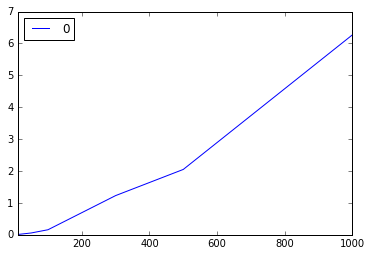

In [292]:
df = pd.DataFrame.from_dict({10:0.00954, 50:0.0567, 100:0.159, 300:1.23, 500:2.05, 1000:6.27},orient='index')
df.sort(0,inplace=1)
df.plot()

In [293]:
flatness_c = 3
flatness_p = 2

from tqdm import *

np.random.seed(0)

def perf(n,m,flatness_c,flatness_p):
    for i in (range(1)):
        C = np.exp(flatness_c*np.random.rand(m,n))
        P = np.exp(flatness_p*np.random.rand(m,n))
        T = np.sum(P)*np.random.rand()
        res, f = genAssign(P,C,T)


%timeit perf(500,2,flatness_c,flatness_p)
%timeit perf(500,5,flatness_c,flatness_p)
%timeit perf(500,10,flatness_c,flatness_p)
%timeit perf(500,20,flatness_c,flatness_p)
%timeit perf(500,30,flatness_c,flatness_p)
%timeit perf(500,50,flatness_c,flatness_p)
%timeit perf(500,100,flatness_c,flatness_p)
%timeit perf(500,500,flatness_c,flatness_p)


1 loop, best of 3: 1.57 s per loop
1 loop, best of 3: 2.11 s per loop
1 loop, best of 3: 3.17 s per loop
1 loop, best of 3: 5.55 s per loop
1 loop, best of 3: 8.24 s per loop
1 loop, best of 3: 15 s per loop
1 loop, best of 3: 34.2 s per loop


KeyboardInterrupt: 

1 loop, best of 3: 1.57 s per loop

1 loop, best of 3: 2.11 s per loop

1 loop, best of 3: 3.17 s per loop

1 loop, best of 3: 5.55 s per loop

1 loop, best of 3: 8.24 s per loop

1 loop, best of 3: 15 s per loop

1 loop, best of 3: 34.2 s per loop

/Users/Chengyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


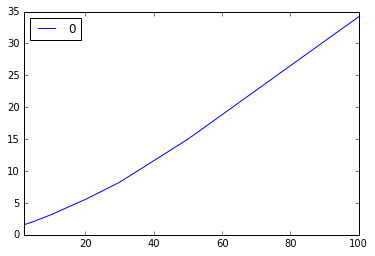

In [3]:
dic={2:1.57,5:2.11,10:3.17,20:5.55,30:8.24,50:15,100:34.2}
df = pd.DataFrame.from_dict(dic,orient='index')
df.sort(0,inplace=1)
df.plot()